In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
import re

# %matplotlib widget 
%matplotlib inline

In [3]:
dir_setup = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test'
# ls /p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo


In [4]:
ncfiles = glob.glob(os.path.join(dir_setup,'input/cosmo/*.nc'))
# ncfiles = xr.load_dataset(os.path.join(dir_setup,'input/clm/fracdata_CLM_cordex0.11_436x424_cosmomask_varpft_noice.nc'))
data = xr.load_dataset(ncfiles[0])
# # data['lon']
# print(data['slonu'][2:5,2:5].values)
print(data['slatu'][0:3,0:3].values)
# print(data['slonv'][0:5,0:5].values)
print(data['slatv'][0:5,0:5].values)
# print(data['lon'][range(0,5),range(0,5)].values)

# data['slonv']
ncfiles

[[20.600565 20.641182 20.681671]
 [20.701069 20.741747 20.782299]
 [20.80156  20.8423   20.882914]]
[[20.630447 20.671158 20.711742 20.752197 20.792526]
 [20.730913 20.771687 20.812332 20.85285  20.89324 ]
 [20.831366 20.872202 20.91291  20.953491 20.993942]
 [20.931805 20.972704 21.013474 21.054117 21.094631]
 [21.03223  21.07319  21.114025 21.15473  21.195305]]


['/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo/lbff00090000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo/lbff00060000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo/lbff00000000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo/laf2021062412.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo/lbff00030000.nc',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/cosmo/lbff00120000.nc']

In [5]:
class RegexDict(dict):

    def get_matching(self, event):
        for key in self:
            if re.match(key,event):
                return self[key]


def div_n(x):
    x_ = x / n_coarse
    return x_[:,0]

def median_round(x,round_='up'):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    x_ = x.median(axis=(1,3))
    if round_ == 'down':
         #   x_[x_ < 1] = 0    
        mask = ~(x_<1) #everything smaller than 1 will get assigned sea
        x_ = x_.where(mask).fillna(0)

    elif round_ == 'up':
        # x_[x_ > 0] = 1
        mask = ~(x_ > 0) #everything larger than 0 will get assigned land
        x_ = x_.where(mask).fillna(1)
        
    return x_

def lower_corner(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    return x[:,0,:,0]

def upper_corner(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    return x[:,-1,:,-1]

def centre(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    i_take = int(n_coarse / 2)
    assert n_coarse%2 == 0
    return x[:,i_take,:,i_take]

def sum_cells(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    return x.sum(axis=(1,3))

def mean_cells(x):
    i_yfine = x.dims.index('y_fine')
    i_xfine = x.dims.index('x_fine')
    return x.mean(axis=(i_yfine,i_xfine))

def most_common(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    vals = np.unique(x)

    grid_most_common = np.zeros([x.shape[0],x.shape[2]])
    grid_n_vals = np.zeros([x.shape[0],x.shape[2]])
    
    #initialize return dataset
    grid_return = x.median(axis=(1,3))
    
    #loop through each unique value, check number (n) of values per aggregated grid, set to new value if n is larger than previous
    for val_ in vals:
        mask_val = (x == val_)
        n_val = mask_val.sum(axis=(1,3)).values

        mask_apply = (n_val > grid_n_vals) #>: equal amounts -> favour smaller index; >=: equal amounts -> favour larger index
        grid_most_common[mask_apply] = val_
        grid_n_vals[mask_apply] = n_val[mask_apply]
        
    grid_return.values = grid_most_common
    return grid_return

dict_fn = RegexDict({'NUMLON':'div_n','LONGXY':'centre','LATIXY':'centre',
           'LANDMASK':'median_round','LANDFRAC':'median_round',
           'LONE':'upper_corner','LATN':'upper_corner','LONW':'lower_corner','LATS':'lower_corner',
           'AREA':'sum_cells','TOPO':'mean_cells','LANDFRAC_PFT':'median_round','PFTDATA_MASK':'median_round',
           'SOIL_COLOR':'most_common','PCT_(.*)':'mean_cells','MONTHLY_(.*)':'mean_cells'})

list_coarsen = [fracdata,griddata,topodata,surfdata]
dict_data_coarse = {'fracdata':None,'griddata':None,'topodata':None,'surfdata':None}

for data_,name_ in zip(list_coarsen,dict_data_coarse.keys()):

    print('coarsening %s' % name_)

    data_coarse = data_.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').median()
    data_regions = data_.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').construct(lsmlon=("lsmlon", "x_fine"), lsmlat=("lsmlat", "y_fine"))

    for var_ in data_regions.keys():

        fn_agg = dict_fn.get_matching(var_)    
        if fn_agg is not None:
            data_coarse[var_] = locals()[fn_agg](data_regions[var_])

    
    dict_data_coarse[name_] = data_coarse

NameError: name 'fracdata' is not defined

ValueError: too many values to unpack (expected 2)

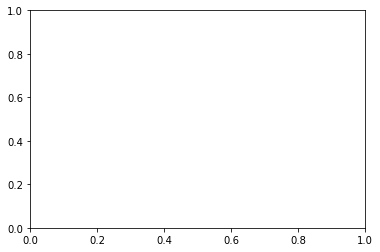

In [28]:
plt.figure()
plt.pcolormesh((data['U'][0,-1,:,:]**2+data['V'][0,-1,:,:]**2),cmap=plt.cm.jet)
plt.colorbar()

# data['ROOTDP']
data['U']

In [30]:
data['U'][0,-1,:,:]**2 + data['V'][0,-1,:,:]**2

<xarray.DataArray (rlat: 432, srlon: 444, srlat: 432, rlon: 444)>
array([[[[2.32758179e+01, 2.33574829e+01, 2.35508308e+01, ...,
          6.31252480e+01, 6.23283730e+01, 6.04075317e+01],
         [2.34274578e+01, 2.38556881e+01, 2.42195110e+01, ...,
          6.25870438e+01, 6.10941162e+01, 5.89410362e+01],
         [2.41103477e+01, 2.45065651e+01, 2.49780350e+01, ...,
          6.08048439e+01, 5.93481674e+01, 5.67256889e+01],
         ...,
         [2.12263947e+02, 2.23391449e+02, 2.26830383e+02, ...,
          6.76528778e+01, 6.23045425e+01, 5.75281830e+01],
         [2.08648438e+02, 2.14893463e+02, 2.15550629e+02, ...,
          6.47481613e+01, 6.07185974e+01, 5.66190834e+01],
         [2.07347168e+02, 2.13000977e+02, 2.11138306e+02, ...,
          6.11513443e+01, 5.86175194e+01, 5.47122192e+01]],

        [[2.19493599e+01, 2.20310249e+01, 2.22243729e+01, ...,
          6.17987900e+01, 6.10019150e+01, 5.90810738e+01],
         [2.21009998e+01, 2.25292301e+01, 2.28930531e+01, ...,
          6.12605858e+01, 5.97676582e+01, 5.76145782e+01],
         [2.27838898e+01, 2.31801071e+01, 2.36515770e+01, ...,
          5.94783859e+01, 5.80217094e+01, 5.53992310e+01],
...
          5.08894920e+01, 4.55411606e+01, 4.07648010e+01],
         [1.91885056e+02, 1.98130096e+02, 1.98787262e+02, ...,
          4.79847794e+01, 4.39552155e+01, 3.98557014e+01],
         [1.90583786e+02, 1.96237610e+02, 1.94374924e+02, ...,
          4.43879623e+01, 4.18541374e+01, 3.79488373e+01]],

        [[7.59391069e+00, 7.67557478e+00, 7.86892319e+00, ...,
          4.74433403e+01, 4.66464653e+01, 4.47256241e+01],
         [7.74555016e+00, 8.17378139e+00, 8.53760338e+00, ...,
          4.69051361e+01, 4.54122086e+01, 4.32591286e+01],
         [8.42844105e+00, 8.82465744e+00, 9.29612732e+00, ...,
          4.51229362e+01, 4.36662598e+01, 4.10437813e+01],
         ...,
         [1.96582047e+02, 2.07709534e+02, 2.11148483e+02, ...,
          5.19709663e+01, 4.66226349e+01, 4.18462753e+01],
         [1.92966522e+02, 1.99211563e+02, 1.99868729e+02, ...,
          4.90662537e+01, 4.50366898e+01, 4.09371758e+01],
         [1.91665253e+02, 1.97319077e+02, 1.95456390e+02, ...,
          4.54694366e+01, 4.29356117e+01, 3.90303116e+01]]]],
      dtype=float32)
Coordinates:
  * rlat     (rlat) float32 -24.47 -24.36 -24.25 -24.14 ... 22.72 22.83 22.94
  * srlon    (srlon) float32 -29.42 -29.31 -29.2 -29.09 ... 19.09 19.2 19.31
    slonu    (rlat, srlon) float32 -10.53 -10.43 -10.33 ... 68.44 68.64 68.84
    slatu    (rlat, srlon) float32 20.6 20.64 20.68 20.72 ... 67.0 66.93 66.87
    time     datetime64[ns] 2021-06-24T12:00:00
  * rlon     (rlon) float32 -29.47 -29.36 -29.25 -29.14 ... 19.04 19.15 19.26
  * srlat    (srlat) float32 -24.42 -24.31 -24.2 -24.09 ... 22.77 22.88 22.99
    slonv    (srlat, rlon) float32 -10.6 -10.5 -10.4 ... 68.44 68.63 68.83
    slatv    (srlat, rlon) float32 20.63 20.67 20.71 20.75 ... 67.08 67.01 66.94